In [1]:
import numpy as np
import cv2
import functools
import matplotlib.pyplot as plt
from skimage.io import imshow

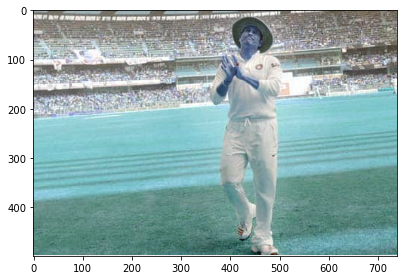

In [2]:
img=cv2.imread("Sachin2.png")
imshow(img)

In [8]:
img.shape

(499, 738, 3)

In [3]:
def compute_grad(img):
    grad_x=cv2.Sobel(img,cv2.CV_32F,1,0)
    grad_y=cv2.Sobel(img,cv2.CV_32F,0,1)
    r,theta=cv2.cartToPolar(grad_x,grad_y)
    imshow(grad_x)
    return r,theta

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


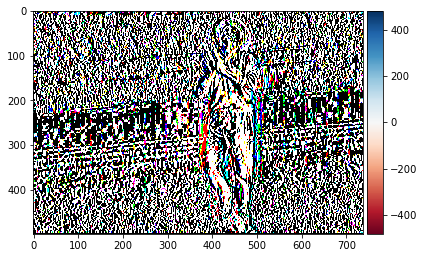

In [4]:
r,theta=compute_grad(img)

In [6]:
r.shape

(499, 738, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


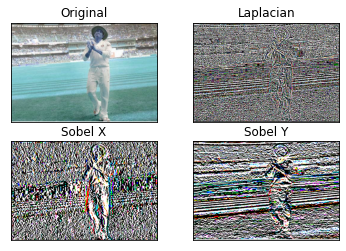

In [11]:
laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

<br>Total numbers of Bins=6 
<br>One cell=8*8 pixels
<br>One block = 2*2 Cells
<br>Hence one block=64*4=256 pixels

In [2]:
import numpy as np
import cv2
import functools
import matplotlib.pyplot as plt
from skimage.io import imshow

#Numbers of bins 
N_BUCKETS=6

#number of pixels in a cell_row,cell_column
CELL_SIZE=8

#number of cells in a block_row,block_column
BLOCK_SIZE=2



def assign_bucket_vals(m,d,bucket_vals):
    #print(m)
    left_bin=int(d/30.)
    right_bin=(int(d/30.)+1) % N_BUCKETS
    #print(left_bin)
    left_val=m*(right_bin*30-d)/30
    right_val=m*(left_bin*30+d)/30
    bucket_vals[left_bin] += left_val
    bucket_vals[right_bin] +=right_val

    
    
    
def get_magnitude_hist_cell(loc_x,loc_y):
    cell_x=G_x[loc_x:loc_x + CELL_SIZE, loc_y:loc_y + CELL_SIZE]
    cell_y=G_y[loc_x:loc_x + CELL_SIZE, loc_y:loc_y + CELL_SIZE]
    #print(cell_y)
    for i in cell_x:
        for j in range(len(i)):
            if i[j]==0:
                i[j]=0.1

    magnitudes = np.sqrt(cell_x * cell_x + cell_y * cell_y)
    directions=np.abs(np.arctan(cell_y / cell_x)* 180 / np.pi)
    #print(magnitudes)
    buckets=np.linspace(0,180,N_BUCKETS+1)
    bucket_vals=np.zeros(N_BUCKETS)
    #print(directions.flatten())

    for m,d in zip(magnitudes.flatten(), directions.flatten()):
        assign_bucket_vals(m, d, bucket_vals)

    '''map(
43
    lambda (m, d): assign_bucket_vals(m, d, bucket_vals), 
44
        zip(magnitudes.flatten(), directions.flatten())
45
    )'''

    return bucket_vals




def get_magnitude_hist_block(loc_x,loc_y):
    return functools.reduce(
        lambda arr1, arr2: np.concatenate((arr1, arr2)),
        [get_magnitude_hist_cell(x, y) for x, y in zip(
            [loc_x, loc_x + CELL_SIZE, loc_x, loc_x + CELL_SIZE],
            [loc_y, loc_y, loc_y + CELL_SIZE, loc_y + CELL_SIZE],
        )]
    )



<ipython-input-2-d894c75c5012>:41: RuntimeWarning: divide by zero encountered in true_divide
  directions=np.abs(np.arctan(cell_y / cell_x)* 180 / np.pi)


Text(0.5, 1.0, 'HOG of block at [450, 60]')

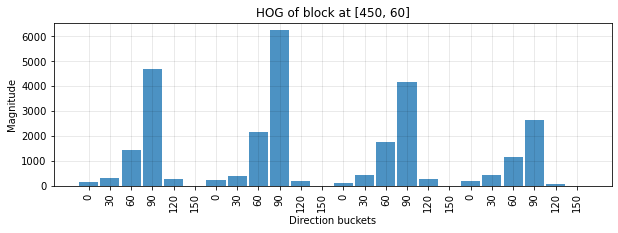

In [5]:
import numpy as np
import scipy.signal
import cv2


img = cv2.imread("Sachin2.png")
img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#print(img)
#Define the Sobel operator kernels.

kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

G_x = scipy.signal.convolve2d(img, kernel_x, mode='same') 
G_y = scipy.signal.convolve2d(img, kernel_y, mode='same') 

#print(G_x)






#Give  a  particular pixel location to find the histogram values
loc_x=450
loc_y=60
ydata=get_magnitude_hist_block(loc_x,loc_y)
#print(ydata)

for i in range(len(ydata)):
    if ydata[i]==0.:
        ydata[i]=1.
        
#ydata=ydata/np.linalg.norm(ydata)

xdata=range(len(ydata))
bucket_names=np.tile(np.arange(N_BUCKETS), BLOCK_SIZE * BLOCK_SIZE)


plt.figure(figsize=(10, 3))
plt.bar(xdata, ydata, align='center', alpha=0.8, width=0.9)
plt.xticks(xdata, bucket_names * 30, rotation=90)
plt.xlabel('Direction buckets')
plt.ylabel('Magnitude')
plt.grid(color='k', alpha=0.1)
plt.title("HOG of block at [%d, %d]" % (loc_x, loc_y))
